In [78]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
import math

In [79]:
dataset_path = Path().resolve()/"HomeC.csv"
df = pd.read_csv(dataset_path)
type(df)

C:\Users\user\anaconda3\envs\time-series-labs\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (0,27) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


pandas.core.frame.DataFrame

In [80]:
# clean data 
#remove kW
df.columns = [i.replace(' [kW]', '') for i in df.columns]
#combine similar objects
df['Furnace'] = df[['Furnace 1','Furnace 2']].sum(axis=1)
df['Kitchen'] = df[['Kitchen 12','Kitchen 14','Kitchen 38']].sum(axis=1)
#remove unused objects; icon and summary are objects that cannot be passed into calculation; use column same as House overall column and gen column same as Solar column
df.drop(['Furnace 1','Furnace 2','Kitchen 12','Kitchen 14','Kitchen 38','icon','House overall','summary','Solar'],axis = 1,inplace = True)
#remove last row as the values are NaN
df = df[0:-1] ## == dataset[0:dataset.shape[0]-1] == dataset[0:len(dataset)-1] == dataset[:-1]
#replace object in cloudCover with float
df['cloudCover'].replace(['cloudCover'], method='bfill', inplace=True)
df['cloudCover'] = df['cloudCover'].astype('float')
#set date time as index and drop time column
date_time = pd.date_range('2016-01-01 13:00',periods=len(df), freq='min')
df = df.set_index(date_time)
df = df.drop(['time'],axis=1)
df

,use,gen,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,...,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,Furnace,Kitchen
2016-01-01 13:00:00,0.932833,0.003483,0.000033,0.442633,0.124150,0.006983,0.013083,0.031350,0.001017,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.082617,0.000567
2016-01-01 13:01:00,0.934333,0.003467,0.000000,0.444067,0.124000,0.006983,0.013117,0.031500,0.001017,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.084533,0.000567
2016-01-01 13:02:00,0.931817,0.003467,0.000017,0.446067,0.123533,0.006983,0.013083,0.031517,0.001000,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.083017,0.000617
2016-01-01 13:03:00,1.022050,0.003483,0.000017,0.446583,0.123133,0.006983,0.013000,0.031500,0.001017,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.175417,0.000650
2016-01-01 13:04:00,1.139400,0.003467,0.000133,0.446533,0.122850,0.006850,0.012783,0.031500,0.001017,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.300917,0.000783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-16 11:25:00,1.601233,0.003183,0.000050,0.041783,0.005267,0.008667,0.013483,0.032283,0.000983,0.003800,...,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51,0.727683,0.000633
2016-12-16 11:26:00,1.599333,0.003233,0.000050,0.041750,0.005233,0.008433,0.013433,0.032200,0.000950,0.003800,...,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51,0.729050,0.000600
2016-12-16 11:27:00,1.924267,0.003217,0.000033,0.042033,0.004983,0.008467,0.012933,0.032283,0.001000,0.003750,...,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51,1.060117,0.000600
2016-12-16 11:28:00,1.978200,0.003217,0.000050,0.042100,0.005333,0.008233,0.012817,0.032183,0.000950,0.003767,...,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51,1.116033,0.000650


In [96]:
# aggregate the data in minutes into data in days 
data_per_hour = df.resample("H").mean()
data_per_day = data_per_hour.resample("D").sum()
data_per_day

,use,gen,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,...,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,Furnace,Kitchen
2016-01-01,9.417778,0.200255,0.000824,0.691284,0.542605,0.240183,0.143272,0.362742,0.223651,0.073737,...,330.669333,11174.639667,73.897333,6.800000,2906.433333,0.000000,270.629333,0.000000,4.765534,0.088768
2016-01-02,31.626046,0.471918,2.042966,2.279903,1.882561,0.577329,0.320778,1.870687,0.470141,0.301686,...,602.919000,24340.640667,193.174667,9.133667,6326.900000,0.002127,488.261000,0.038667,11.342408,0.296948
2016-01-03,28.959138,1.408606,0.887142,2.496879,1.557047,0.361409,0.315809,3.071866,0.636696,0.151049,...,614.380333,24277.099667,184.704000,5.054667,5545.666667,0.000000,473.955000,0.000000,10.302853,0.281709
2016-01-04,26.952957,1.220068,1.267151,3.302783,1.177844,0.553069,0.324846,2.426134,0.629122,0.414216,...,509.999000,24282.393667,228.987667,4.586000,6976.100000,0.000000,434.107000,0.000000,9.796212,0.303804
2016-01-05,30.928413,2.020197,1.801527,2.647929,1.393185,0.335486,0.322667,0.781315,0.559865,0.279284,...,-41.031333,24709.530667,238.982000,1.144333,7653.266667,0.000000,-67.162333,0.000000,13.854020,0.327031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-12,25.067204,0.819387,0.002078,0.994067,1.124719,0.914141,0.348257,0.797237,0.429433,0.078471,...,731.185833,24627.271000,182.985833,13.005667,3742.466667,0.025840,682.694833,0.855000,10.087758,0.191488
2016-12-13,24.970885,0.354978,1.174588,0.993098,1.405512,0.583564,0.365563,0.799179,0.377117,0.118382,...,842.614000,24263.552333,238.461667,6.694167,6908.183333,0.000000,720.549500,0.000000,8.303074,0.218923
2016-12-14,16.578193,0.612870,0.001521,0.990616,1.257123,0.467855,0.323806,0.817596,0.188008,0.103343,...,621.301333,24443.842833,155.045000,5.536500,5304.933333,0.000623,499.327000,0.011333,8.294401,0.095407
2016-12-15,23.310524,1.062173,1.218033,1.009138,1.039280,0.615826,0.343723,0.782956,0.233434,0.694959,...,638.276833,23989.695000,167.074833,8.878167,5403.400000,0.236622,672.656167,5.315500,11.173807,0.099210


<AxesSubplot:>

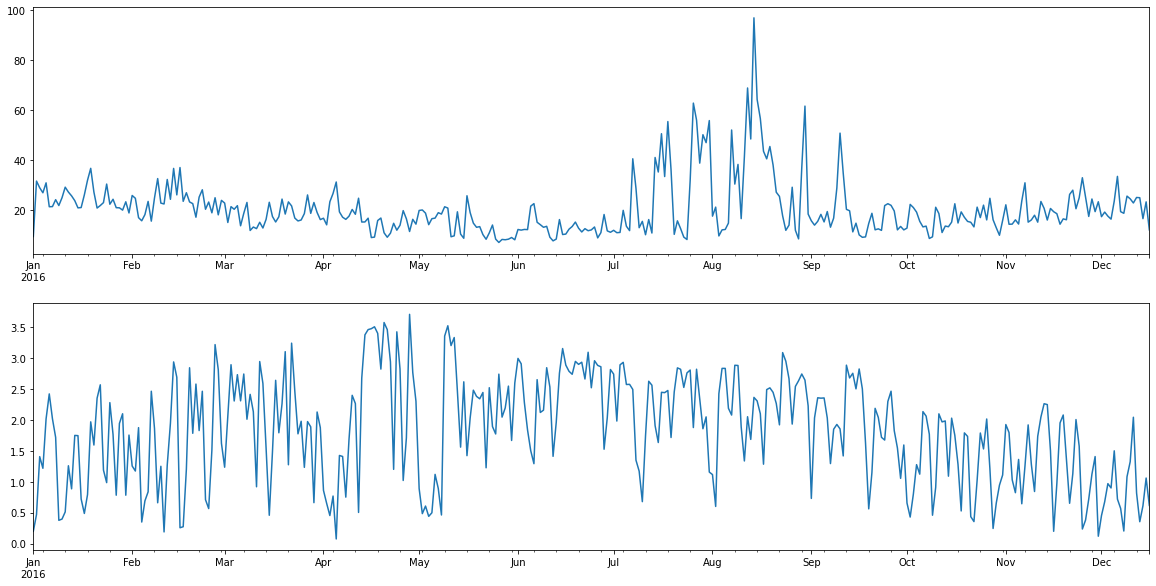

In [97]:
fig, axes = plt.subplots(nrows=2, ncols =1)
data_per_day["use"].plot(ax=axes[0],figsize = (20,10))
data_per_day["gen"].plot(ax=axes[1],figsize = (20,10))

# Naive Method

In [98]:
data_per_day["naive"] = data_per_day["use"].shift(1)
data_per_day

,use,gen,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,...,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,Furnace,Kitchen,naive
2016-01-01,9.417778,0.200255,0.000824,0.691284,0.542605,0.240183,0.143272,0.362742,0.223651,0.073737,...,11174.639667,73.897333,6.800000,2906.433333,0.000000,270.629333,0.000000,4.765534,0.088768,NaN
2016-01-02,31.626046,0.471918,2.042966,2.279903,1.882561,0.577329,0.320778,1.870687,0.470141,0.301686,...,24340.640667,193.174667,9.133667,6326.900000,0.002127,488.261000,0.038667,11.342408,0.296948,9.417778
2016-01-03,28.959138,1.408606,0.887142,2.496879,1.557047,0.361409,0.315809,3.071866,0.636696,0.151049,...,24277.099667,184.704000,5.054667,5545.666667,0.000000,473.955000,0.000000,10.302853,0.281709,31.626046
2016-01-04,26.952957,1.220068,1.267151,3.302783,1.177844,0.553069,0.324846,2.426134,0.629122,0.414216,...,24282.393667,228.987667,4.586000,6976.100000,0.000000,434.107000,0.000000,9.796212,0.303804,28.959138
2016-01-05,30.928413,2.020197,1.801527,2.647929,1.393185,0.335486,0.322667,0.781315,0.559865,0.279284,...,24709.530667,238.982000,1.144333,7653.266667,0.000000,-67.162333,0.000000,13.854020,0.327031,26.952957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-12,25.067204,0.819387,0.002078,0.994067,1.124719,0.914141,0.348257,0.797237,0.429433,0.078471,...,24627.271000,182.985833,13.005667,3742.466667,0.025840,682.694833,0.855000,10.087758,0.191488,22.867584
2016-12-13,24.970885,0.354978,1.174588,0.993098,1.405512,0.583564,0.365563,0.799179,0.377117,0.118382,...,24263.552333,238.461667,6.694167,6908.183333,0.000000,720.549500,0.000000,8.303074,0.218923,25.067204
2016-12-14,16.578193,0.612870,0.001521,0.990616,1.257123,0.467855,0.323806,0.817596,0.188008,0.103343,...,24443.842833,155.045000,5.536500,5304.933333,0.000623,499.327000,0.011333,8.294401,0.095407,24.970885
2016-12-15,23.310524,1.062173,1.218033,1.009138,1.039280,0.615826,0.343723,0.782956,0.233434,0.694959,...,23989.695000,167.074833,8.878167,5403.400000,0.236622,672.656167,5.315500,11.173807,0.099210,16.578193


In [99]:
rmse_naive = math.sqrt(mean_squared_error(data_per_day.iloc[-90:][["use"]], data_per_day[-90:][["naive"]]))
mape_naive = mean_absolute_percentage_error(data_per_day[-90:][["use"]], data_per_day[-90:][["naive"]])
print("The RMSE of naive forecast is: ", rmse_naive)
print("The MAPE of naive forecast is: ", mape_naive)

The RMSE of naive forecast is:  5.671368825614021
The MAPE of naive forecast is:  0.24574554385756414


# Exponential Weighted Moving Average

In [111]:
# we use ewm function
data_per_day["ewma_2"] = data_per_day["use"].ewm(span = 2).mean()
data_per_day["ewma_2"] = data_per_day["ewma_2"].shift(1)
data_per_day

,use,gen,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,...,dewPoint,precipProbability,Furnace,Kitchen,naive,ewma_2,ewma_3,ewma_7,ewma_14,ewma_30
2016-01-01,9.417778,0.200255,0.000824,0.691284,0.542605,0.240183,0.143272,0.362742,0.223651,0.073737,...,270.629333,0.000000,4.765534,0.088768,NaN,NaN,9.417778,9.417778,9.417778,9.417778
2016-01-02,31.626046,0.471918,2.042966,2.279903,1.882561,0.577329,0.320778,1.870687,0.470141,0.301686,...,488.261000,0.038667,11.342408,0.296948,9.417778,9.417778,24.223290,22.108217,21.315064,20.892050
2016-01-03,28.959138,1.408606,0.887142,2.496879,1.557047,0.361409,0.315809,3.071866,0.636696,0.151049,...,473.955000,0.000000,10.302853,0.281709,31.626046,26.073979,26.929489,25.070777,24.235126,23.762272
2016-01-04,26.952957,1.220068,1.267151,3.302783,1.177844,0.553069,0.324846,2.426134,0.629122,0.414216,...,434.107000,0.000000,9.796212,0.303804,28.959138,28.071397,26.942005,25.759117,25.066587,24.641422
2016-01-05,30.928413,2.020197,1.801527,2.647929,1.393185,0.335486,0.322667,0.781315,0.559865,0.279284,...,-67.162333,0.000000,13.854020,0.327031,26.952957,27.316450,28.999506,27.453534,26.595929,26.071865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-12,25.067204,0.819387,0.002078,0.994067,1.124719,0.914141,0.348257,0.797237,0.429433,0.078471,...,682.694833,0.855000,10.087758,0.191488,22.867584,23.335636,24.227559,23.528170,22.802796,21.697747
2016-12-13,24.970885,0.354978,1.174588,0.993098,1.405512,0.583564,0.365563,0.799179,0.377117,0.118382,...,720.549500,0.000000,8.303074,0.218923,25.067204,24.490015,24.599222,23.888848,23.091875,21.908917
2016-12-14,16.578193,0.612870,0.001521,0.990616,1.257123,0.467855,0.323806,0.817596,0.188008,0.103343,...,499.327000,0.011333,8.294401,0.095407,24.970885,24.810595,20.588708,22.061185,22.223384,21.565000
2016-12-15,23.310524,1.062173,1.218033,1.009138,1.039280,0.615826,0.343723,0.782956,0.233434,0.694959,...,672.656167,5.315500,11.173807,0.099210,16.578193,19.322327,21.949616,22.373520,22.368336,21.677614


In [112]:
data_per_day["ewma_3"] = data_per_day["use"].ewm(span = 3).mean()
data_per_day["ewma_3"] = data_per_day["ewma_3"].shift(1)

In [113]:
data_per_day["ewma_7"] = data_per_day["use"].ewm(span = 7).mean()
data_per_day["ewma_7"] = data_per_day["ewma_7"].shift(1)

In [114]:
data_per_day["ewma_14"] = data_per_day["use"].ewm(span = 14).mean()
data_per_day["ewma_14"] = data_per_day["ewma_14"].shift(1)

In [115]:
data_per_day["ewma_30"] = data_per_day["use"].ewm(span = 30).mean()
data_per_day["ewma_30"] = data_per_day["ewma_30"].shift(1)

<AxesSubplot:>

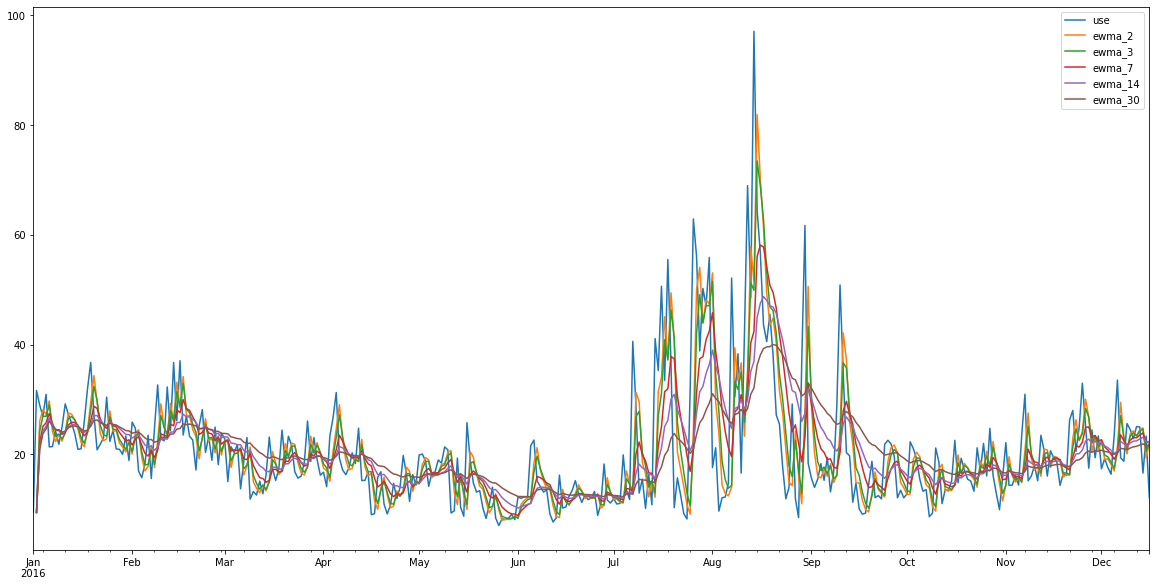

In [116]:
data_per_day[["use", "ewma_2", "ewma_3", "ewma_7", "ewma_14", "ewma_30"]].plot(figsize=(20,10))

<AxesSubplot:>

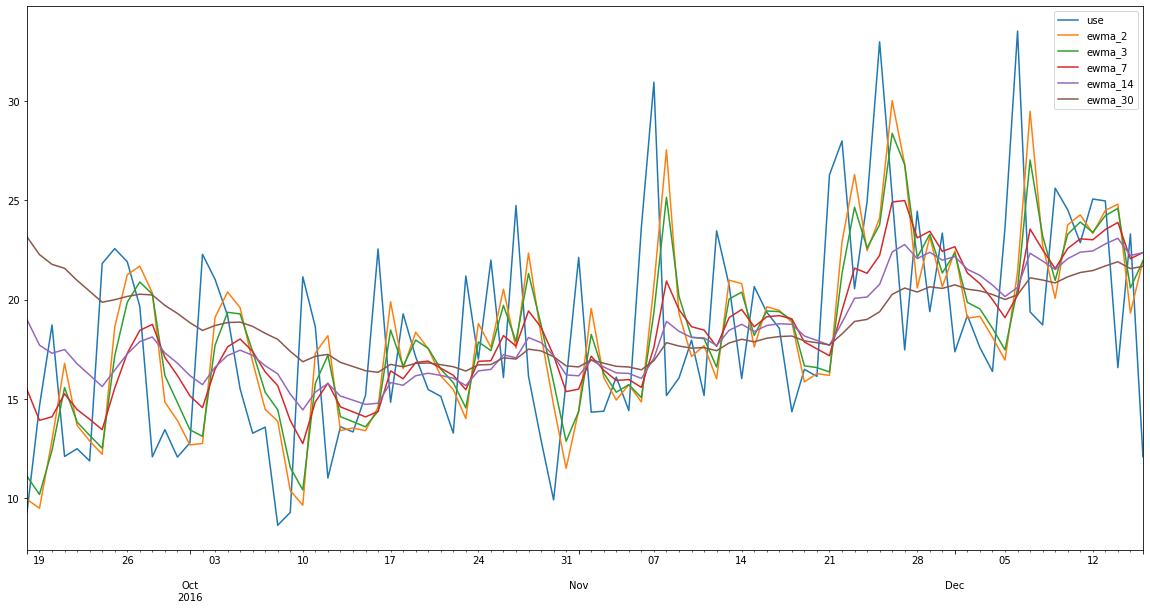

In [117]:
data_per_day.iloc[-90:][["use", "ewma_2", "ewma_3", "ewma_7", "ewma_14", "ewma_30"]].plot(figsize=(20, 10))

In [118]:
rmse_ewma_2 = math.sqrt(mean_squared_error(data_per_day.iloc[-90:][["use"]], data_per_day.iloc[-90:][["ewma_2"]]))
rmse_ewma_3 = math.sqrt(mean_squared_error(data_per_day.iloc[-90:][["use"]], data_per_day.iloc[-90:][["ewma_3"]]))
rmse_ewma_7 = math.sqrt(mean_squared_error(data_per_day.iloc[-90:][["use"]], data_per_day.iloc[-90:][["ewma_7"]]))
rmse_ewma_14 = math.sqrt(mean_squared_error(data_per_day.iloc[-90:][["use"]], data_per_day.iloc[-90:][["ewma_14"]]))
rmse_ewma_30 = math.sqrt(mean_squared_error(data_per_day.iloc[-90:][["use"]], data_per_day.iloc[-90:][["ewma_30"]]))

In [119]:
print("The RMSE of exponential weighted moving average of 2 span is : ", rmse_ewma_2)
print("The RMSE of exponential weighted moving average of 3 span is : ", rmse_ewma_3)
print("The RMSE of exponential weighted moving average of 7 span is : ", rmse_ewma_7)
print("The RMSE of exponential weighted moving average of 14 span is : ", rmse_ewma_14)
print("The RMSE of exponential weighted moving average of 30 span is : ", rmse_ewma_30)

The RMSE of exponential weighted moving average of 2 span is :  5.250662114350892
The RMSE of exponential weighted moving average of 3 span is :  5.0992979008285175
The RMSE of exponential weighted moving average of 7 span is :  4.9078044737364745
The RMSE of exponential weighted moving average of 14 span is :  4.884378213440908
The RMSE of exponential weighted moving average of 30 span is :  5.301224846229861


In [120]:
mape_ewma_2 = mean_absolute_percentage_error(data_per_day.iloc[-90:][["use"]], data_per_day.iloc[-90:][["ewma_2"]])
mape_ewma_3 = mean_absolute_percentage_error(data_per_day.iloc[-90:][["use"]], data_per_day.iloc[-90:][["ewma_3"]])
mape_ewma_7 = mean_absolute_percentage_error(data_per_day.iloc[-90:][["use"]], data_per_day.iloc[-90:][["ewma_7"]])
mape_ewma_14 = mean_absolute_percentage_error(data_per_day.iloc[-90:][["use"]], data_per_day.iloc[-90:][["ewma_14"]])
mape_ewma_30 = mean_absolute_percentage_error(data_per_day.iloc[-90:][["use"]], data_per_day.iloc[-90:][["ewma_30"]])

In [121]:
print("The MAPE of exponential weighted moving average of 2 span is : ", mape_ewma_2)
print("The MAPE of exponential weighted moving average of 3 span is : ", mape_ewma_3)
print("The MAPE of exponential weighted moving average of 7 span is : ", mape_ewma_7)
print("The MAPE of exponential weighted moving average of 14 span is : ", mape_ewma_14)
print("The MAPE of exponential weighted moving average of 30 span is : ", mape_ewma_30)

The MAPE of exponential weighted moving average of 2 span is :  0.22920945802431628
The MAPE of exponential weighted moving average of 3 span is :  0.22740239458610026
The MAPE of exponential weighted moving average of 7 span is :  0.22427411695850516
The MAPE of exponential weighted moving average of 14 span is :  0.2298029870555805
The MAPE of exponential weighted moving average of 30 span is :  0.25774330285360064
